In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
# https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2022-01-14 03:54:41--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  19.9MB/s    in 2.9s    

2022-01-14 03:54:45 (19.9 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [ ]:
!unzip -nq UCI-HAR.zip

In [ ]:
# Values are acquired by exploring the dataset
# Can be explored manually from the zip file previously imported

T = 128 # number of columns
Ntrain = 7352 # number of train rows
Ntest = 2947 # number of test rows
D = 9 # number of files
K = 6 # number of classes in activity_labels.txt

In [ ]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  # Preallocating Xtrain and Xtest arrays
  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = ['body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
                  'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
                  'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt']
  
  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}',
                     header = None, delim_whitespace = True)
    
    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x

  # Train labels
  Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt',
                         header = None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  # Test data
  ts_filenames = ['body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
                    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
                    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt']

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}',
                       header = None, delim_whitespace = True)
    
    # Ntest x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

  # Test labels
  Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt',
                         header = None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

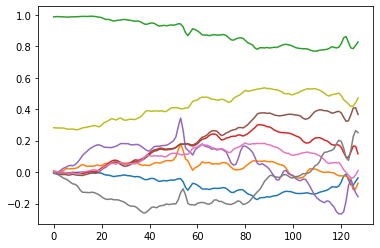

In [ ]:
# Plot all D = 9 time series of length T = 128

plt.plot(Xtrain[7000, :, :]);

## CNN

In [ ]:
# CNN

i = Input(shape = (T, D))
x = Conv1D(32, 5, activation = 'relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           1472      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 128)           24704 

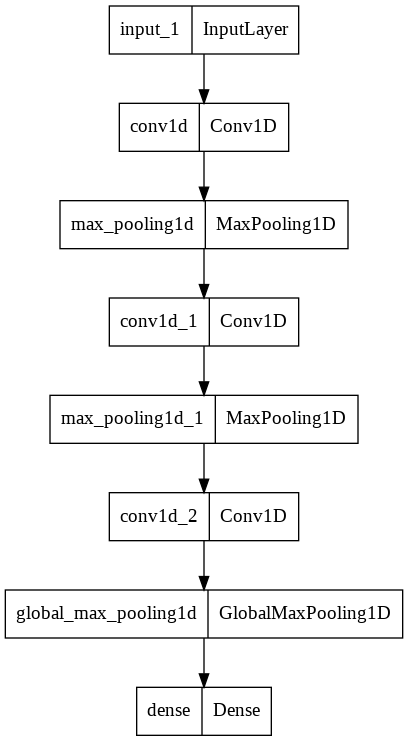

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# 1st argument file name
# 2nd argument metrics taken
# 3rd argument equals True to only save the best model

check_point = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True)

In [ ]:
model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Call fit function

r = model.fit(Xtrain, Ytrain, epochs = 15,
              callbacks = [check_point], validation_data = (Xtest, Ytest))

Epoch 1/15
230/230 [==============================] - 5s 17ms/step - loss: 0.3705 - accuracy: 0.8794 - val_loss: 0.2490 - val_accuracy: 0.9063
Epoch 2/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1256 - accuracy: 0.9489 - val_loss: 0.2203 - val_accuracy: 0.9182
Epoch 3/15
230/230 [==============================] - 3s 15ms/step - loss: 0.1182 - accuracy: 0.9505 - val_loss: 0.2047 - val_accuracy: 0.9162
Epoch 4/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1145 - accuracy: 0.9508 - val_loss: 0.2075 - val_accuracy: 0.9277
Epoch 5/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1032 - accuracy: 0.9558 - val_loss: 0.1768 - val_accuracy: 0.9393
Epoch 6/15
230/230 [==============================] - 4s 15ms/step - loss: 0.0985 - accuracy: 0.9581 - val_loss: 0.2274 - val_accuracy: 0.9152
Epoch 7/15
230/230 [==============================] - 4s 15ms/step - loss: 0.0997 - accuracy: 0.9567 - val_loss: 0.2179 - val_accuracy: 0.9213

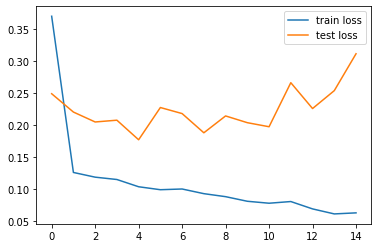

In [ ]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

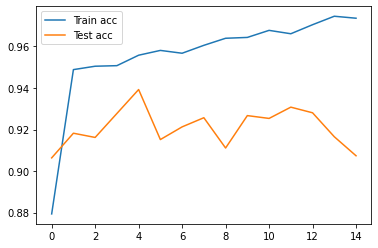

In [ ]:
# Plot train and validation accuracy

plt.plot(r.history['accuracy'], label = 'Train acc')
plt.plot(r.history['val_accuracy'], label = 'Test acc')
plt.legend();

In [ ]:
# Load best model

best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# Make predictions

Ptest = best_model.predict(Xtest)

In [ ]:
# Evaluate accuracy
# Ptest = N x K matrix of probabilities
# To convert it to labels we need argmax to find the max value. The result is a 
# 1D array of predictive labels

# After the predictive labels acquired, == Ytest is used to do an element wise
# Use the .mean to get the average of the array (accuracy)

np.mean(np.argmax(Ptest, axis = 1) == Ytest)

0.9392602646759416

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header = None,
                   delim_whitespace = True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header = None,
                   delim_whitespace = True)
  
  feat_test = df.to_numpy()

  ss = StandardScaler()
  feat_train = ss.fit_transform(feat_train)
  feat_test = ss.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [ ]:
# Determine the dimentionality of the features (number of columns in both arrays)

D_feat = feat_train.shape[1]

In [ ]:
# CNN

i = Input(shape = (T, D))
x = Conv1D(32, 5, activation = 'relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

# ANN

# Create input layer with dimensionality D_feat
i2 = Input(shape = (D_feat,))

# Create 1st hidden layer size of 64 with relu
x2 = Dense(64, activation = 'relu')(i2) 

# Output layer Dense of output size Kx = Concatenate()([x, x2])
x = Dense(K)(x) 

# Instantiate model object passing the input and output
model = Model([i, i2], x)

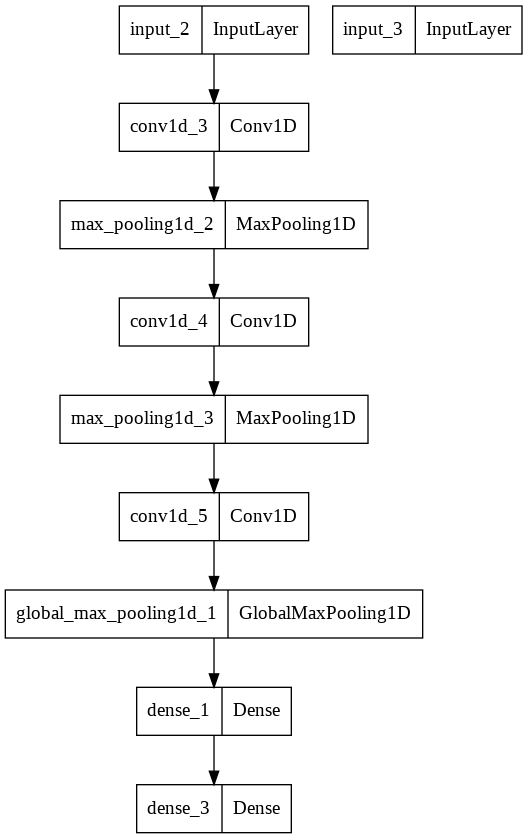

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
check_point2 = ModelCheckpoint('best_model_basic.h5', monitor = 'val_accuracy',
                               save_best_only = True)

In [ ]:
model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
# Call fit function

r = model.fit([Xtrain, feat_train], Ytrain, epochs = 15, callbacks = [check_point2],
              validation_data = ([Xtest, feat_test], Ytest))

Epoch 1/15
230/230 [==============================] - 4s 16ms/step - loss: 0.4065 - accuracy: 0.8592 - val_loss: 0.2728 - val_accuracy: 0.9006
Epoch 2/15
230/230 [==============================] - 3s 15ms/step - loss: 0.1253 - accuracy: 0.9497 - val_loss: 0.2220 - val_accuracy: 0.9179
Epoch 3/15
230/230 [==============================] - 3s 15ms/step - loss: 0.1163 - accuracy: 0.9513 - val_loss: 0.2081 - val_accuracy: 0.9175
Epoch 4/15
230/230 [==============================] - 3s 14ms/step - loss: 0.1109 - accuracy: 0.9528 - val_loss: 0.1999 - val_accuracy: 0.9250
Epoch 5/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0978 - accuracy: 0.9574 - val_loss: 0.1769 - val_accuracy: 0.9379
Epoch 6/15
230/230 [==============================] - 4s 15ms/step - loss: 0.0939 - accuracy: 0.9607 - val_loss: 0.1963 - val_accuracy: 0.9216
Epoch 7/15
230/230 [==============================] - 3s 14ms/step - loss: 0.0958 - accuracy: 0.9580 - val_loss: 0.3448 - val_accuracy: 0.8999

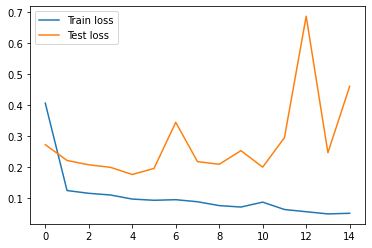

In [ ]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

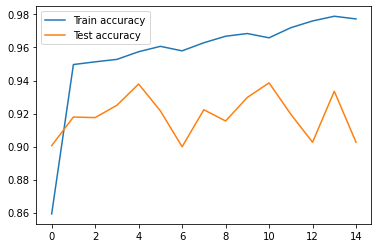

In [ ]:
# Plot train and validation accuracy

plt.plot(r.history['accuracy'], label = 'Train accuracy')
plt.plot(r.history['val_accuracy'], label = 'Test accuracy')
plt.legend();

In [ ]:
# Load best model

best_model = tf.keras.models.load_model('best_model_basic.h5')

In [ ]:
# Make predictions

Ptest = best_model.predict([Xtest, feat_test])

In [ ]:
# Evaluate accuracy
# Ptest = N x K matrix of probabilities
# To convert it to labels we need argmax to find the max value. The result is a 
# 1D array of predictive labels

# After the predictive labels acquired, == Ytest is used to do an element wise
# comparison. It returns an array of boolean (1 = true, 0 = false)

# Use the .mean to get the average of the array (accuracy)

np.mean(np.argmax(Ptest, axis = 1) == Ytest)

0.9385816084153377